# Importing libraries

In [1]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback, EarlyStopping
from sklearn.metrics import confusion_matrix, classification_report

# Load the data

In [2]:
#path="Downloads/project"
#path_img = list(glob.glob(path+'/**/*.jpg'))

In [22]:
path= r"C:\Users\USER\Downloads\project"
path_img = list(glob.glob(path+'/**/*.jpg'))

In [23]:
labels = list(map(lambda x:os.path.split(os.path.split(x)[0])[1], path_img))
file_path = pd.Series(path_img, name='File_Path').astype(str)
labels = pd.Series(labels, name='Labels')
data = pd.concat([file_path, labels], axis=1)
data = data.sample(frac=1).reset_index(drop=True)
data.head()

,File_Path,Labels
0,C:\Users\USER\Downloads\project\pawn_resized\0...,pawn_resized
1,C:\Users\USER\Downloads\project\knight-resize\...,knight-resize
2,C:\Users\USER\Downloads\project\bishop_resized...,bishop_resized
3,C:\Users\USER\Downloads\project\Queen-Resized\...,Queen-Resized
4,C:\Users\USER\Downloads\project\Queen-Resized\...,Queen-Resized


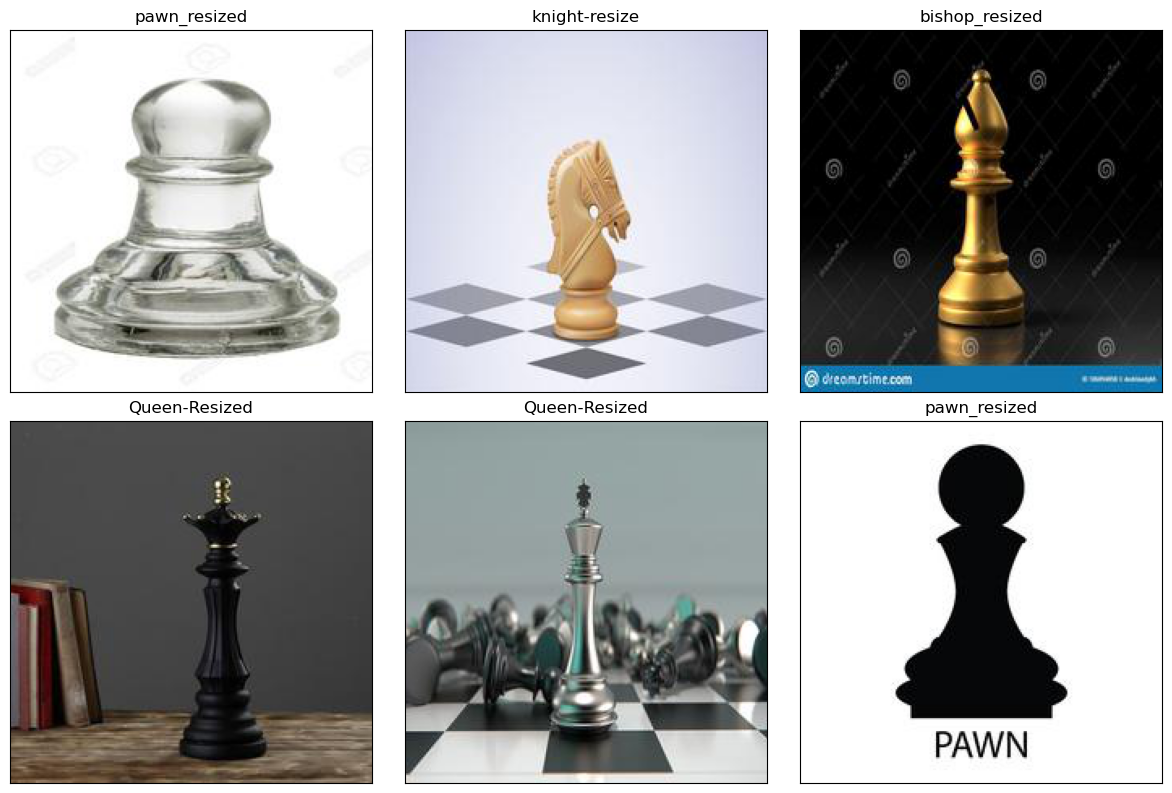

In [24]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(data.File_Path[i]))
    ax.set_title(data.Labels[i])
plt.tight_layout()
plt.show()

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'knight-resize'),
  Text(1, 0, 'bishop_resized'),
  Text(2, 0, 'Rook-resize'),
  Text(3, 0, 'Queen-Resized'),
  Text(4, 0, 'pawn_resized')])

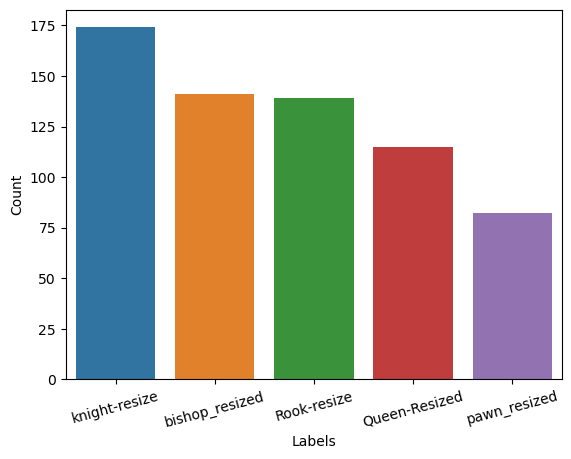

In [25]:
counts=data.Labels.value_counts()
sns.barplot(x=counts.index,y=counts)
plt.xlabel("Labels")
plt.ylabel("Count")
plt.xticks(rotation=15)

# Split into train and test set

In [26]:
train_df, test_df = train_test_split(data, test_size=0.25, random_state=1)

In [27]:
def func(pre,name_model,size):
    print('#####~Model => {} '.format(name_model))
    train_datagen = ImageDataGenerator(preprocessing_function=pre, validation_split=0.2)
    test_datagen = ImageDataGenerator(preprocessing_function=pre)
    
    train_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=True,
        seed=0,
        subset='training',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    valid_gen = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        class_mode='categorical',
        batch_size=32,
        shuffle=False,
        seed=0,
        subset='validation',
        rotation_range=30,
        zoom_range=0.15,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.15,
        horizontal_flip=True,
        fill_mode="nearest")
    test_gen = test_datagen.flow_from_dataframe(
        dataframe=test_df,
        x_col='File_Path',
        y_col='Labels',
        target_size=(size,size),
        color_mode='rgb',
        class_mode='categorical',
        batch_size=32,
        verbose=0,
        shuffle=False)
    
    pre_model = name_model(input_shape=(size,size, 3),
                   include_top=False,
                   weights='imagenet',
                   pooling='avg')
    pre_model.trainable = False
    inputs = pre_model.input
    x = Dense(64, activation='relu')(pre_model.output)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(5, activation='softmax')(x)
    model = Model(inputs=inputs, outputs=outputs)
    model.compile(loss = 'categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])
    my_callbacks  = [EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              mode='auto')]
    
    history = model.fit(train_gen,validation_data=valid_gen,epochs=100,callbacks=my_callbacks,verbose=0);
    print('\033[01m              Plotting Accuracy, val_accuracy, loss, val_loss \033[0m')
    # Plotting Accuracy, val_accuracy, loss, val_loss
    fig, ax = plt.subplots(1, 2, figsize=(10, 3))
    ax = ax.ravel()

    for i, met in enumerate(['accuracy', 'loss']):
        ax[i].plot(history.history[met])
        ax[i].plot(history.history['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['Train', 'Validation'])
    plt.show()
    
    # Predict Data Test
    pred = model.predict(test_gen )
    pred = np.argmax(pred,axis=1)
    labels = (train_gen.class_indices)
    labels = dict((v,k) for k,v in labels.items())
    pred = [labels[k] for k in pred]
    
    print('\033[01m              Classification_report \033[0m')
    # Classification report
    cm=confusion_matrix(test_df.Labels,pred)
    clr = classification_report(test_df.Labels, pred)
    print(clr)
    print('\033[01m Display 6 pictures of the dataset with their labels \033[0m')
    # Display 6 pictures of the dataset with their labels
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12, 8),
                        subplot_kw={'xticks': [], 'yticks': []})

    for i, ax in enumerate(axes.flat):
        ax.imshow(plt.imread(test_df.File_Path.iloc[i+1]))
        ax.set_title(f"True: {test_df.Labels.iloc[i+1]}\nPredicted: {pred[i+1]}")
    plt.tight_layout()
    plt.show()
    
    print('\033[01m              Results \033[0m')
    # Results
    results = model.evaluate(test_gen, verbose=0)
    print("    Test Loss:\033[31m \033[01m {:.5f} \033[30m \033[0m".format(results[0]))
    print("Test Accuracy:\033[32m \033[01m {:.2f}% \033[30m \033[0m".format(results[1] * 100))
    
    return results

# Using InceptionResNetV2 as backbone

#####~Model => <function InceptionResNetV2 at 0x000001E522847640> 
Found 391 validated image filenames belonging to 5 classes.
Found 97 validated image filenames belonging to 5 classes.
Found 163 validated image filenames belonging to 5 classes.
219055592/219055592 [==============================] - 313s 1us/step
              Plotting Accuracy, val_accuracy, loss, val_loss 


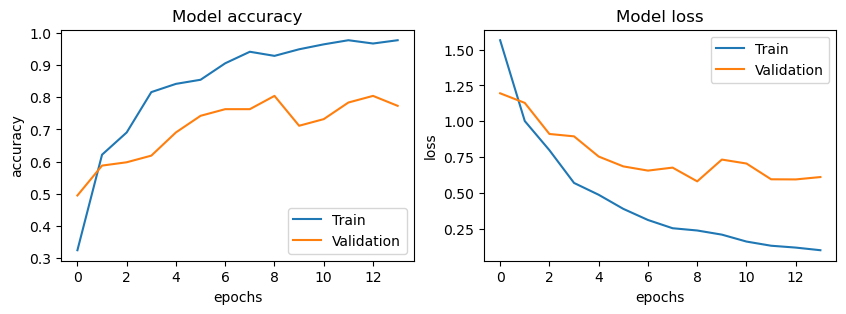

6/6 [==============================] - 41s 5s/step
              Classification_report 
                precision    recall  f1-score   support

 Queen-Resized       0.91      0.70      0.79        30
   Rook-resize       0.83      0.77      0.80        31
bishop_resized       0.73      0.90      0.80        41
 knight-resize       0.87      0.94      0.90        35
  pawn_resized       0.82      0.69      0.75        26

      accuracy                           0.82       163
     macro avg       0.83      0.80      0.81       163
  weighted avg       0.82      0.82      0.81       163

 Display 6 pictures of the dataset with their labels 


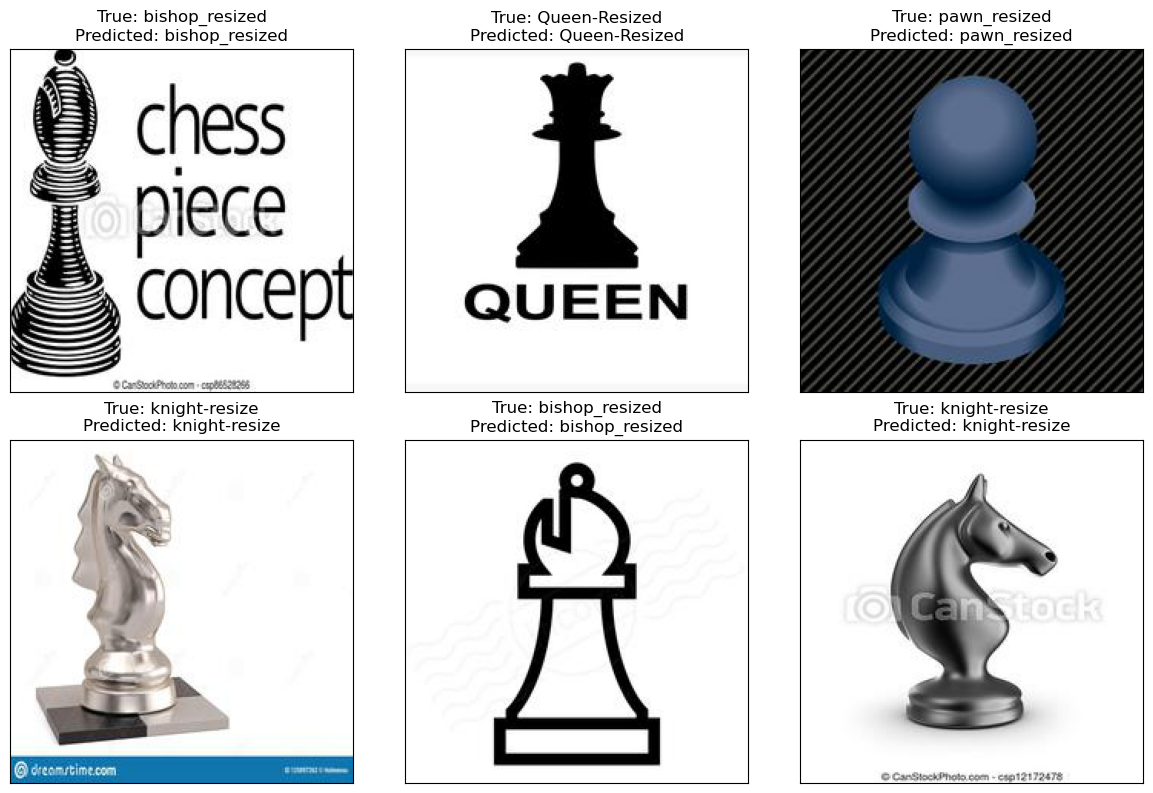

              Results 
    Test Loss:  0.62627  
Test Accuracy:  81.60%  


In [29]:
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input
result_InceptionResNetV2 = func(preprocess_input,InceptionResNetV2,224)